This notebook is for testing the visuals for the dashboard and for making the html version of the folium map. Making it directly in streamlit takes way too much time.

In [1]:
import streamlit as st
import numpy as np
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
from folium.plugins import GroupedLayerControl
from folium.plugins import FeatureGroupSubGroup
import geopandas as gpd
import pandas as pd
from streamlit_folium import st_folium
from pathlib import Path
import branca.colormap as cm
from collections import defaultdict
from folium.plugins import MarkerCluster
from sklearn.cluster import DBSCAN

# Import visualize function to make things more organized
# from Map_function_dashboard import visualize_map

In [2]:
def DutchRDtoWGS84(rdX, rdY):
    """ Convert DutchRD to WGS84
    """
    RD_MINIMUM_X = 11000
    RD_MAXIMUM_X = 280000
    RD_MINIMUM_Y = 300000
    RD_MAXIMUM_Y = 630000
    if (rdX < RD_MINIMUM_X or rdX > RD_MAXIMUM_X
        or rdY < RD_MINIMUM_Y or rdY > RD_MAXIMUM_Y):
        resultNorth = -1
        resultEast = -1
        return resultNorth, resultEast
    # else
    dX = (rdX - 155000.0) / 100000.0
    dY = (rdY - 463000.0) / 100000.0
    k = [[3600 * 52.15517440, 3235.65389, -0.24750, -0.06550, 0.0],
        [-0.00738   ,   -0.00012,  0.0    ,  0.0    , 0.0],
        [-32.58297   ,   -0.84978, -0.01709, -0.00039, 0.0],
        [0.0       ,    0.0    ,  0.0    ,  0.0    , 0.0],
        [0.00530   ,    0.00033,  0.0    ,  0.0    , 0.0],
        [0.0       ,    0.0    ,  0.0    ,  0.0    , 0.0]]
    l = [[3600 * 5.38720621,    0.01199,  0.00022,  0.0    , 0.0],
        [5260.52916   ,  105.94684,  2.45656,  0.05594, 0.00128],
        [-0.00022   ,    0.0    ,  0.0    ,  0.0    , 0.0],
        [-0.81885   ,   -0.05607, -0.00256,  0.0    , 0.0],
        [0.0       ,    0.0    ,  0.0    ,  0.0    , 0.0],
        [0.00026   ,    0.0    ,  0.0    ,  0.0    , 0.0]]
    resultNorth = 0
    resultEast = 0
    powX = 1

    for p in range(6):
        powY = 1
        for q in range(5):
            resultNorth = resultNorth + k[p][q] * powX * powY / 3600.0
            resultEast = resultEast + l[p][q] * powX * powY / 3600.0
            powY = powY * dY
        powX = powX * dX
    return resultNorth, resultEast



# @st.cache_resource
def visualize_map(speed, incidents, opt_list):
    """
    Visualize the final map with layers
    """

    # Create map
    map = folium.Map(location=[52.399190, 4.893658])

    no_speed = folium.FeatureGroup(overlay=False, name='Show no speed')
    max_speed = folium.FeatureGroup(overlay=False, show=True, name='Maximum speed limit')
    peak_speed = folium.FeatureGroup(overlay=False, name='Average speed during peak hours')
    
    no_incidents = folium.FeatureGroup(name='Show no incidents')
    incidents_heatmap = folium.FeatureGroup(name='Incidents heatmap')
    incident_clusters = folium.FeatureGroup(name='Incident clusters')


    cluster_opt = folium.FeatureGroup(overlay=True, show=True, name='Method 1: K-means method based on distance - optimal conditions')
    cluster_opt_peak = folium.FeatureGroup(overlay=True, show=False, name='Method 1: K-means method based on distance - peak hour')

    cluster2_opt = folium.FeatureGroup(overlay=True, show=True, name='Method 2: K-means method based on travel time - optimal conditions')
    ml_opt = folium.FeatureGroup(overlay=True, show=True, name='Method 3: Simulated Annealing - optimal conditions')


    # Colormaps for speed
    colormap = cm.LinearColormap(colors=['red','green'], vmin=70, vmax=130)
    colormap = colormap.to_step(index=[70, 80, 90, 100, 110, 120, 130])
    colormap.caption = 'Speed of the cars [km/h]'
    colormap.add_to(map)

    nan_color = cm.LinearColormap(colors=['white', 'white'])


    # Create right coordinates
    speed['coords'] = speed.geometry.apply(lambda geom: list(geom.coords))

    # Loop over all road sections for speed
    for i in speed.index:
        
        # Get coordinates to right coordinate system
        updated_coords = []

        for j in range(len(speed['coords'][i])):
            # st.write(i, j)
            # st.write(speed['coords'][i][j][0])
            new_cords = DutchRDtoWGS84(speed['coords'][i][j][0], speed['coords'][i][j][1])
            updated_coords.append(new_cords)
        
        # Add color lines for max speed
        if speed['Max_speed'][i] != speed['Max_speed'][i]:
            max_color = nan_color
        else:
            max_color = colormap

        folium.ColorLine(
            positions = updated_coords, # tuple of coordinates 
            colors = [speed['Max_speed'][i]] * (len(updated_coords) - 1), # map each segment with the speed 
            colormap =  max_color, # map each value with a color 
            weight = 3
            ).add_to(max_speed)
        

        # Add color lines for peak hour speed
        if speed['Peak_speed'][i] != speed['Peak_speed'][i]:
            peak_color = nan_color
        else:
            peak_color = colormap

        folium.ColorLine(
            positions = updated_coords, # tuple of coordinates 
            colors = [speed['Peak_speed'][i]] * (len(updated_coords) - 1), # map each segment with the speed 
            colormap =  peak_color, # map each value with a color 
            weight = 3
            ).add_to(peak_speed)

    # Create heatmap incidents
    new_data = incidents.loc[incidents['type'] == 'accident']
    # Extract the latitude and longitude as a list of lists
    heat_data = [[row['latitude'], row['longitude']] for _, row in new_data.iterrows()]
    # Create a heatmap layer
    HeatMap(heat_data).add_to(incidents_heatmap)

    # Create clusters
    eps = 0.1
    min_samples = 100
    data = incidents
    # Create a DBSCAN clustering model
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='haversine', algorithm='ball_tree')

    # Fit the model to the latitude and longitude data
    dbscan.fit(data[['latitude', 'longitude']].values)

    # Assign cluster labels to data points
    data['cluster'] = dbscan.labels_

    # Filter out noise points (-1 labels)
    clustered_data = data[data['cluster'] != -1]

    # Create a MarkerCluster layer for clustered data
    marker_cluster = MarkerCluster().add_to(incident_clusters)

    # Add markers for clustering
    for _, row in clustered_data.iterrows():
        popup_text = f"Cluster: {row['cluster']}<br>Type: {row['type']}<br>Index: {row['index']}"
        folium.Marker([row['latitude'], row['longitude']], icon=None, popup=popup_text).add_to(marker_cluster)


    color = ['red', 'blue', 'green', 'orange']
    opt = [cluster_opt, cluster_opt_peak, cluster2_opt, ml_opt]
    # Optimization method 1
    for m in range(len(opt_list)):

        for i in range(len(opt_list[m])):
            icon=folium.Icon(color=color[m])
            opt[m].add_child(folium.Marker((opt_list[m]['0'][i], 
                                                 opt_list[m]['1'][i]), icon=icon))

    

    no_speed.add_to(map)
    max_speed.add_to(map)
    peak_speed.add_to(map)


    no_incidents.add_to(map)
    incidents_heatmap.add_to(map)
    incident_clusters.add_to(map)

    cluster_opt.add_to(map)
    cluster_opt_peak.add_to(map)
    cluster2_opt.add_to(map)
    ml_opt.add_to(map)

    # folium.LayerControl(overlay=True, collapsed=False).add_to(map)

    GroupedLayerControl(
            groups={
                    '_________Speed_________': [max_speed, peak_speed, no_speed],
                    '________Incidents________':[no_incidents, incidents_heatmap, incident_clusters],},
            
            # exclusive_groups=False,
            collapsed=True,
            ).add_to(map)
    
    
    GroupedLayerControl(
            groups={'Optimization methods': opt},
            collapsed=False, exclusive_groups=False,
            ).add_to(map)

    return map

In [3]:
speed = gpd.read_file('Dashboard_data\speed_data.shp')
incidents = pd.read_csv('Dashboard_data\incidents_data', sep=';')

In [4]:
cluster_min_inspector_loc = pd.read_csv('Dashboard_data\Optimization_results\cluster_min_inspector_locations.csv', sep=';')
cluster_min_travel_time = pd.read_csv('Dashboard_data\Optimization_results\cluster_min_travel_time_to_incident.csv', sep=';')

cluster_peak_inspector_loc = pd.read_csv('Dashboard_data\Optimization_results\cluster_peak_inspector_locations.csv', sep=';')
cluster_peak_travel_time = pd.read_csv('Dashboard_data\Optimization_results\cluster_peak_travel_time_to_incident.csv', sep=';')

ml_inspector_loc = pd.read_csv('Dashboard_data\Optimization_results\ml_inspector_loc.csv')
cluster2_inspector_loc = pd.read_csv('Dashboard_data\Optimization_results\cluster2_inspector_loc.csv')

In [5]:
cluster2_loc = np.zeros((len(cluster2_inspector_loc), 2))

for i in range(len(cluster2_loc)):
    cluster2_loc[i] = np.array(cluster2_inspector_loc['Location'][i].split()).astype(float)

cluster2_loc_df = pd.DataFrame(cluster2_loc, columns=['0', '1'])

In [6]:
# cluster2_loc_df['1']

In [7]:
opt_results = [cluster_min_inspector_loc, cluster_peak_inspector_loc, 
               cluster2_loc_df, ml_inspector_loc]

In [22]:
# # Loading this code takes up too much space. Uncomment this when editing the map
# map = visualize_map(speed, incidents, opt_results)
# map

In [23]:
# # Save map as html
# # Uncomment this when making new version of the map
# map.save('Dashboard_data\Dashboard_map.html')

In [9]:
incidents_df = incidents
incidents_df['start_time'] = pd.to_datetime(incidents_df['start_time'])
incidents_df['end_time'] = pd.to_datetime(incidents_df['end_time'])

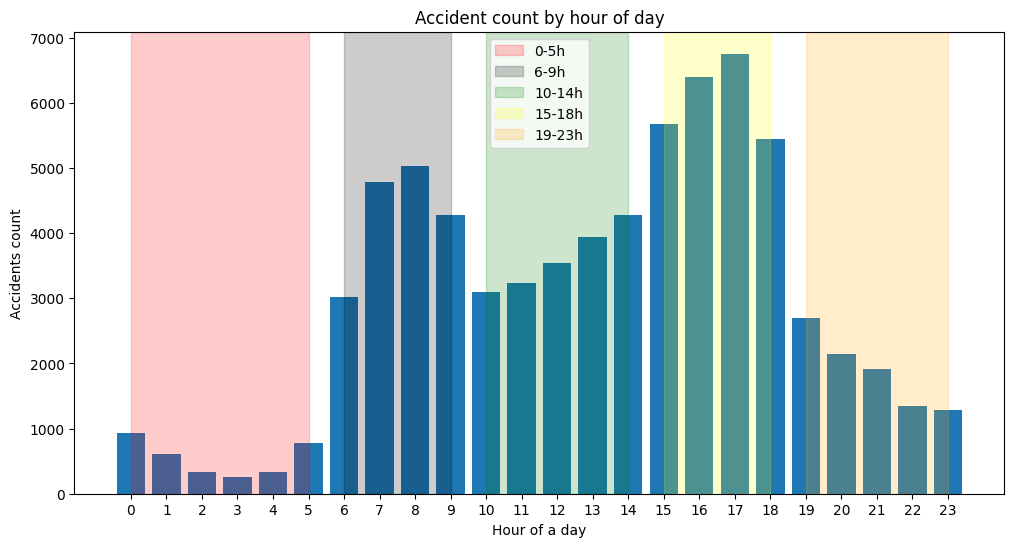

In [10]:


def bar_chart_incidents():

    incidents_df['hour_of_day'] = incidents_df['start_time'].apply(lambda x: x.hour)
    hourly_counts = incidents_df.groupby('hour_of_day').size().reset_index(name='accident_count')

    fig = plt.figure(figsize=(12, 6))
    plt.bar(hourly_counts['hour_of_day'], hourly_counts['accident_count'])
    plt.xlabel('Hour of a day')
    plt.ylabel('Accidents count')
    plt.title('Accident count by hour of day')
    plt.xticks(hourly_counts['hour_of_day'])

    plt.axvspan(0, 5, alpha=0.2, color='red', label='0-5h')
    plt.axvspan(6, 9, alpha=0.2, color='black', label='6-9h')
    plt.axvspan(10, 14, alpha=0.2, color='green', label='10-14h')
    plt.axvspan(15, 18, alpha=0.2, color='yellow', label='15-18h')
    plt.axvspan(19, 23, alpha=0.2, color='orange', label='19-23h')
    plt.legend()

    return fig

fig = bar_chart_incidents()

In [11]:
fig.savefig('Dashboard_data\incident_day.png')

Text(0.5, 1.0, 'Boxplot of speed distribution')

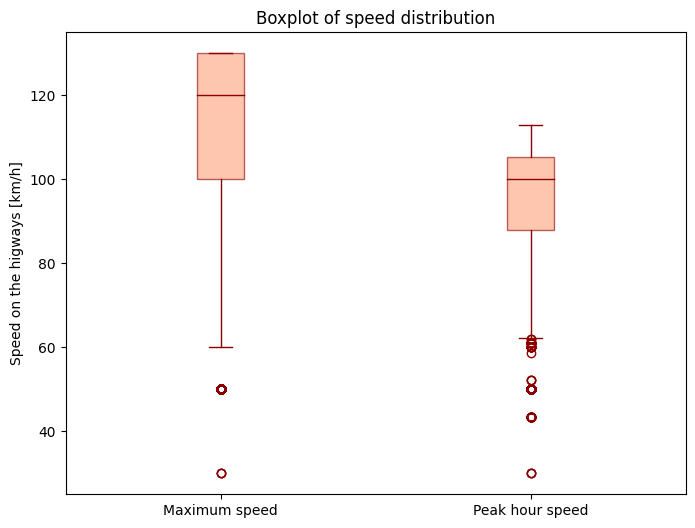

In [12]:
fig_2 = plt.figure(figsize=(8, 6))

category = ['Max_speed', 'Peak_speed']

for i in range(2):
    bp = plt.boxplot(speed[category[i]], patch_artist=True, 
                showmeans=False, positions=[i])

    for item in ['boxes', 'whiskers', 'medians', 'caps']:
            plt.setp(bp[item], color='darkred')

    plt.setp(bp['boxes'], facecolor='lightsalmon', alpha=0.6)
    plt.setp(bp['fliers'], markeredgecolor='darkred')

plt.ylabel('Speed on the higways [km/h]')
plt.xticks([0, 1], labels=['Maximum speed', 'Peak hour speed'])
plt.title('Boxplot of speed distribution')


In [13]:
fig_2.savefig('Dashboard_data\Speed_boxplot.png')

## Boxplots for time differences 

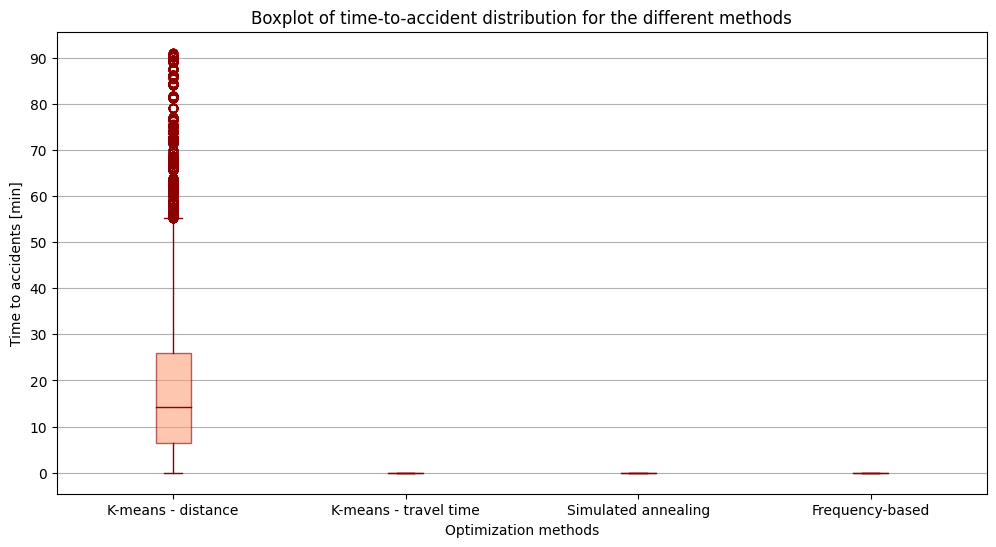

In [20]:
fig_2 = plt.figure(figsize=(12, 6))

category = ['K-means - distance', 'K-means - travel time', 'Simulated annealing', 'Frequency-based']
methods = [cluster_min_travel_time['time_this'] / 60, [0], [0], [0]]

for i in range(4):
    bp = plt.boxplot(methods[i], patch_artist=True, 
                showmeans=False, positions=[i])

    for item in ['boxes', 'whiskers', 'medians', 'caps']:
            plt.setp(bp[item], color='darkred')

    plt.setp(bp['boxes'], facecolor='lightsalmon', alpha=0.6)
    plt.setp(bp['fliers'], markeredgecolor='darkred')

plt.ylabel('Time to accidents [min]')
plt.xlabel('Optimization methods')
plt.xticks(np.arange(4), labels=category)
plt.yticks(np.arange(0, 100, 10))
plt.title('Boxplot of time-to-accident distribution for the different methods')
plt.grid(axis='y')

In [21]:
fig_2.savefig('Dashboard_data\Opt_boxplot.png')

## Overview results

In [13]:
def get_mean(data):
    """"Returns string of mean travel time in minutes"""
    m = data.mean()

    minutes = m // 60
    seconds = m % 60

    if seconds < 10:
        result = f'{minutes:.0f}:0{seconds:.0f}'
    else:
        result = f'{minutes:.0f}:{seconds:.0f}'

    return result

def get_median(data):
    """"Returns string of mean travel time in minutes"""
    m = data.median()

    minutes = m // 60
    seconds = m % 60

    if seconds < 10:
        result = f'{minutes:.0f}:0{seconds:.0f}'
    else:
        result = f'{minutes:.0f}:{seconds:.0f}'

    return result

In [17]:
data = {'Method': ['K-means - distance', 'K-means - travel time', 'Simulated annealing', 'Frequency-based'],
    'No. of inspectors': [len(cluster_min_inspector_loc), len(cluster2_loc_df), len(ml_inspector_loc), 0],
    'Average travel time [min:sec]': [get_mean(cluster_min_travel_time['time_this']), 0, 0, 0],
    'Median travel time [min:sec]': [get_median(cluster_min_travel_time['time_this']), 0, 0, 0]}

results = pd.DataFrame(data)


In [18]:
results

,Method,No. of inspectors,Average travel time [min:sec],Median travel time [min:sec]
0,K-means - distance,47,17:59,14:09
1,K-means - travel time,60,0,0
2,Simulated annealing,50,0,0
3,Frequency-based,0,0,0


In [19]:
results.to_csv('Dashboard_data\Results_df')

Now for peak hour conditions:

In [31]:
data = {'Method': ['Clustering', 'method2', 'method3', 'method4'],
    'No. of inspectors': [len(cluster_peak_inspector_loc), 0, 0, 0],
    'Average travel time [min:sec]': [get_mean(cluster_peak_travel_time['time_this']), 0, 0, 0],
    'Median travel time [min:sec]': [get_median(cluster_peak_travel_time['time_this']), 0, 0, 0]}

results = pd.DataFrame(data)

results

,Method,No. of inspectors,Average travel time [min:sec],Median travel time [min:sec]
0,Clustering,84,19:52,13:58
1,method2,0,0,0
2,method3,0,0,0
3,method4,0,0,0


In [32]:
results.to_csv('Dashboard_data\Results_peak_df')

Load dataframes to check if saving went correctly

In [54]:
pd.read_csv('Dashboard_data\Results_df', index_col=0)

,Method,No. of inspectors,Average travel time [min:sec],Median travel time [min:sec]
0,Clustering 1,47,17:59,14:09
1,Clustering 2,60,0,0
2,Machine Learning,50,0,0
3,Frequency-based,0,0,0


In [33]:
pd.read_csv('Dashboard_data\Results_peak_df', index_col=0)

,Method,No. of inspectors,Average travel time [min:sec],Median travel time [min:sec]
0,Clustering,84,19:52,13:58
1,method2,0,0,0
2,method3,0,0,0
3,method4,0,0,0
